In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import random
import sys
import json
import pathlib

import nxsdk.api.n2a as nx

import encoding
import radar

In [2]:
# Only the 900 first samples contain information
# lin rate encoding 
# config_file = "scenario1_default.json"
#ttsp encoding
config_file = "scenario4_timecoding.json"
fpath, dft_args = radar.load_config(config_file)
data_cube = radar.bbm_read(fpath)
print(len(data_cube[0]))
#### only 1D
chirp_n = 77
raw_data = [channel[chirp_n] for channel in data_cube]
print(len(raw_data[0]))

n_samples = 100
#n_samples = raw_data[0].size
n_chirps = 1

### list with len 900
encoded_cube = [radar.data_encoding(ch, dft_args) for ch in raw_data]
#linear_rate_encoding(raw_data, dft_args).astype(int)
#print(encoded_cube)

/home/negin/miniconda2/envs/loihi/nxsdk-apps/tutorials/ipython/sdft/data/BBM/scenario4/samples_ch_3_scenario4.txt
128
900


In [3]:
net = nx.NxNet()



###### TEST

# Create a single compartment
cxProto = nx.CompartmentPrototype(vThMant=150,
                                  biasMant = 0,
                                  biasExp = 6,
                                  compartmentVoltageDecay=0,
                                  compartmentCurrentDecay=4095,
                                  functionalState=2,
                                  logicalCoreId=0)
cx = net.createCompartmentGroup(size=1, prototype=cxProto)

# Create spike generator and schedule spikes every 'dt' time steps to be sent to the compartment
sg = net.createSpikeGenProcess(numPorts=1)

# Connect spike generator to compartment
connProto = nx.ConnectionPrototype(weight=10)
sg.connect(cx, prototype=connProto)


uProbe = cx.probe(nx.ProbeParameter.COMPARTMENT_CURRENT)[0][0]
vProbe = cx.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0][0]
sProbe = cx.probe(nx.ProbeParameter.SPIKE)[0][0]











ingen = net.createSpikeGenProcess(numPorts=n_samples)

l1 = []
l1_g = net.createCompartmentGroup()
for i in range(n_samples):
    l1_p = nx.CompartmentPrototype(vThMant=1000,
                                   biasMant = 0,
                                   biasExp = 6,
                                   compartmentCurrentDecay=4095,
                                   compartmentVoltageDecay=0,
                                   functionalState=2,
                                   logicalCoreId=int(i/10))
    l1.append(net.createCompartment(prototype=l1_p))
l1_g.addCompartments(l1)


#l2 = []
#l2_g = net.createCompartmentGroup()
#for i in range(n_samples):
#    l2_p = nx.CompartmentPrototype(vThMant=10,
#                                   biasMant = 0,
#                                   biasExp = 6,
#                                   compartmentCurrentDecay=4095,
#                                   compartmentVoltageDecay=0,
#                                   functionalState=2,
#                                   logicalCoreId=int(i/30))
#    l2.append(net.createCompartment(prototype=l2_p))
#l2_g.addCompartments(l2)



# Connect spike generators to compartments
in_l1 = nx.ConnectionPrototype()
#l1_l2 = nx.ConnectionPrototype()


diag = np.zeros((n_samples,n_samples), int)
np.fill_diagonal(diag, 1)
#array_data = np.array(encoded_cube)
#in_l1_w = diag * array_data
in_l1_w = diag
#print(array_data)

#l1_l2_w = np.ones((n_samples,n_samples), int)

ingen.connect(l1_g, prototype=in_l1, weight=in_l1_w*100)
#l1_g.connect(l2_g, prototype=l1_l2, weight=l1_l2_w*100)

# weights are FT weights....
# and when we have all the input... then charging phase...

    
l1_p_v = []
#l1_p_s = []
#l2_p_v = []
#l2_p_s = []
#l1_ran = np.random.choice(n_samples, 10)
l1_ran = np.arange(0,100,1)
#l2_ran = np.random.choice(900, 10)

for i in l1_ran:
    l1_p_v.append(l1_g.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0][i])
#    l1_p_s.append(l1_g.probe(nx.ProbeParameter.SPIKE)[0][i])

#for i in l2_ran:
#    l2_p_v.append(l1_g.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0][i])
#    l2_p_s.append(l1_g.probe(nx.ProbeParameter.SPIKE)[0][i])







In [4]:
#### SNIP
compiler = nx.N2Compiler()
board = compiler.compile(net)

path = os.getcwd()
#print(path)


bias_snip = board.createProcess(
    name="biasMgmt",
    includeDir=path,
    cFilePath=path + "/setBias.c", 
    funcName="biasMgmt",
    guardName="doBiasMgmt",
    phase="mgmt")

bias_ch = board.createChannel(b'biasChannel', "int", 1)
bias_ch.connect(None, bias_snip)
t_ch = board.createChannel(b'timeChannel', "int", 1)
t_ch.connect(bias_snip, None)


board.startDriver()

INFO:DRV:  Connecting to 127.0.0.1:35411
INFO:DRV:      Host server up..............Done 0.02s
INFO:DRV:      Compiling Embedded snips....Done 0.13s
INFO:DRV:      Encoding axons/synapses.....Done 0.04s


/home/negin/miniconda2/envs/loihi/lib/python3.5/site-packages/ipykernel_launcher.py:15: NxDeprecationWarning: createProcess will be removed in 0.9 in favor of createSnip
  from ipykernel import kernelapp as app
/home/negin/miniconda2/envs/loihi/lib/python3.5/site-packages/ipykernel_launcher.py:23: NxDeprecationWarning: startDriver is being deprecated. Use start instead.


INFO:HST:  Using Kapoho Bay serial number 435
INFO:HST:  Args chip=0 cpu=0 /home/negin/miniconda2/envs/loihi/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1626875844.140005/launcher_chip0_lmt0.bin --chips=1 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 1.22s
INFO:DRV:      Encoding probes.............Done 0.03s


In [5]:
array_data = np.round(np.array(encoded_cube),3)
condesed = np.split(array_data[0], 9)[0]
#print(condesed)

sim_t = 200
step = 0.01 

intervals_n = 10
#bias = [200, 100] * (int(intervals_n/2))
bias = [1000,1000]
t = []

sg.addSpikes(0, list(range(intervals_n, sim_t, intervals_n)))

for cycle in range(sim_t):
    active_neurons = (condesed < (cycle*step)) & (condesed >= ((cycle-1)*step))
    active_neuron_ports = np.nonzero(active_neurons)[0]
    if active_neuron_ports.size != 0:
        for port in active_neuron_ports:
            #print(str(cycle) + " " +str(port))
            ingen.addSpikes(spikeInputPortNodeIds=port, spikeTimes=[cycle+1])

bias_ch.write(1, [0])
board.run(sim_t, aSync=True)

# Read time of last vTh modification from channel and write next vTh value to channel
for b in bias[1:]:
    t.append(t_ch.read(1)[0])
    bias_ch.write(1, [b])


# Finish and disconnect
board.finishRun()
board.disconnect()

print(t)



INFO:DRV:      Transferring probes.........Done 2.19ms
INFO:DRV:      Configuring registers.......Done 0.08s
INFO:DRV:      Transferring spikes.........Done 0.90ms
INFO:HST:  chip=0 cpu=0 Executing management SNIP to change Bias
INFO:HST:  chip=0 cpu=0 Set bias=0 at t=100
INFO:HST:  chip=0 cpu=0 Executing management SNIP to change Bias
INFO:DRV:      Executing...................Done 1.13s
INFO:HST:  chip=0 cpu=0 Set bias=1000 at t=200
INFO:DRV:      Processing timeseries.......Done 1.00s
INFO:HST:  chip=0 cpu=0 halted, status=0x0
[100]


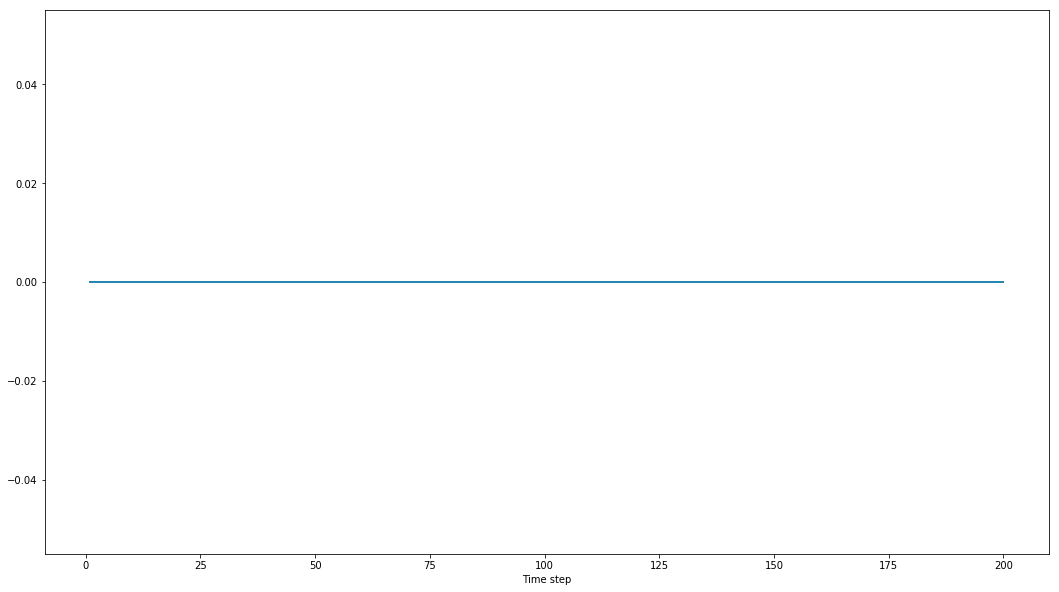

In [6]:
plt.figure(1, figsize=(18,10))

#plt.plot(red_spike_times[1],100 * np.ones(len(red_spike_times[1])), 'bo')

for i in range(len(l1_p_v)):
    #print(red_spike_times[i])
    #if red_spike_times[i][0] <= 100:
        #vprobe[i].plot()
        #plt.plot(red_spike_times[i][0],100, 'bo')
    l1_p_v[i].plot()
    
    #l2_p_v[i].plot()
    #plt.plot(red_spike_times[i],100 * np.ones(len(red_spike_times[i])), 'bo')
vProbe.plot()

In [8]:
# Add initial and final values to 'times' and 'vThVals' that have not been sent for plotting
t.insert(0, 0)
t.append(1000)
vThVals.insert(0, 150)
vThVals.insert(0, 150)
vThVals = vThVals[:-1]

# Helper method to draw vertical interval separators whenever we change vTh
def drawIntervalSeperators(intervalBoundaries):
    for t in intervalBoundaries:
        plt.axvline(x=t, color='k', linestyle='--')

# Plot compartment current, voltage and spikes
plt.figure(1, figsize=(18,10))

ax1 = plt.subplot(3, 1, 1)
uProbe.plot()
plt.title('Compartment Current')
drawIntervalSeperators(times)

ax2 = plt.subplot(3, 1, 2)
vProbe.plot()
plt.title('Compartment Voltage')
plt.step(times, np.array(vThVals)*2**6, color='r', linestyle='--')

ax3 = plt.subplot(3, 1, 3)
sProbe.plot()
plt.title('Compartment Spikes')
drawIntervalSeperators(times)
ax3.set_xlim(ax1.get_xlim())

plt.show()


NameError: name 'vThVals' is not defined